<h1 align="center">Classification of Composers Using Convolutional and Long Short-Term Memory Networks</h1>


This project seeks to accurately predict classical composers like Bach, Beethoven, Chopin and Mozart from musical scores using LSTM and CNN models, addressing the challenges novice listeners face in distinguishing these composers.

Classical music intricately blends art with mathematical principles, presenting a unique opportunity for Machine Learning (ML) application. This project extends these principles to develop AI tools that enhance understanding and appreciation of classical music, serving both educational and analytical purposes in the field.

The project is divided into three distinct sections, each addressing a different computational approache.
1) Convolutional Neural Networks (CNN) to analyze structural patterns and extract foundational features.
2) LSTM Method 1 : Long Short-Term Memory networks (LSTM) for capturing sequential patterns and temporal dynamics.
3) LSTM Method 2: LSTM using fixed sequence tokens to identify and learn distinct, recurring pitch sequences unique to each composer.

In [1]:
#Seema colab setup

from google.colab import drive
drive.mount('/content/drive')

!pip install pretty_midi
!pip install pyfluidsynth
!apt-get install fluidsynth
!apt-get install graphviz
!pip install graphviz pydot

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 19.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592287 sha256=4b709f743ab85d03ad9e107ba811a909699abf7fe5f36088510769865738bfb5
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
  Preparing metadata (setup.py) ... done
  Created wheel for pyfluidsynth: filename=pyFluidSynth-1.3.3-py3-none-any.whl size=19185 sha256=b1887daff41eb351b2c5e8db05bbf67991937f50deedb367c5240480f73bafa2
  Stored in directory: /root/.cac

In [2]:
# Import required libraries
import tensorflow as tf
import os
import numpy as np
import pretty_midi
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
from IPython import display
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix,classification_report
import seaborn as sns
import pickle
from scipy.stats import mode

# Set seed
np.random.seed(42)

"""import warnings
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)"""

"import warnings\n# Suppress FutureWarnings\nwarnings.simplefilter(action='ignore', category=FutureWarning)"

#### Define globals

In [3]:

data_directory = '/content/drive/MyDrive/USD/AAI_511/FinalProject/AAI_511_DeepLearning/data'  #dataset path cloud
#data_directory = './/data'  #dataset path local
# Define the sampling rate
_SAMPLING_RATE = 44100  # Standard audio sampling rate
# SEquence lenght for pitch
sequence_length = 100

### Data Pre-processing


#### Helper functions

In [4]:
# Function to load midi files, composer labels and compser map in seperate arrays

def load_midi_data_and_labels(directory):
    skipped_files = []    # Keep track of skipped files due to errors
    data = []
    composers = []
    num_composer_map = {}
    # Function to recursively iterate files in a directory
    def iterate_dir(dir_path, label, composer):
        # Check direct .mid files in current directory
        for item in os.listdir(dir_path):
            item_path = os.path.join(dir_path, item)
            if os.path.isfile(item_path) and item_path.endswith('.mid'):
                try:
                    # Load the MIDI file
                    midi_data = pretty_midi.PrettyMIDI(item_path)
                    data.append(midi_data)
                    composers.append(label)
                except Exception as e:  # Catch any exception that might be raised
                    print(f"Skipping file {item_path} due to an error: {e}")
                    skipped_files.append(item_path)
            elif os.path.isdir(item_path):
                iterate_dir(item_path, label, composer)
        print(f"Number of files skipped due to error: {len(skipped_files)}")
        return

    # Process each composer's directory in the root directory
    for label, composer in enumerate(sorted(os.listdir(directory))):
        composer_path = os.path.join(directory, composer)
        if os.path.isdir(composer_path):
            num_composer_map[label] = composer
            iterate_dir(composer_path, label, composer)

    return np.array(data), np.array(composers), num_composer_map


In [5]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [6]:
# Load midi files. Skip the erroneous files.
midi_data, composer_labels, composer_map = load_midi_data_and_labels(data_directory)

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Number of files skipped due to error: 0
Skipping file /content/drive/MyDrive/USD/AAI_511/FinalProject/AAI_511_DeepLearning/data/Beethoven/Anhang 14-3.mid due to an error: Could not decode key with 3 flats and mode 255
Number of files skipped due to error: 1
Number of files skipped due to error: 1
Number of files skippe

In [7]:
# Shuffel midi_data, composer_label few times
for i in range(2):
  print("Shuffel:", i)
  # shuffled indices
  indices = np.arange(midi_data.shape[0])
  np.random.shuffle(indices)

  # Shuffling both midi_data and composer_labels_in using same indices
  midi_data = midi_data[indices]
  composer_labels = composer_labels[indices]

Shuffel: 0
Shuffel: 1


In [8]:
"""################### Quick Test#############################################################################################################################

midi_data = midi_data[0:30]
composer_labels = composer_labels[0:30]
"""

'################### Quick Test#############################################################################################################################\n\nmidi_data = midi_data[0:30]\ncomposer_labels = composer_labels[0:30]\n'

In [9]:
midi_data.shape

(1528,)

In [10]:
# Play first loaded midi file
#display_audio(midi_data[0])

### Data Augmentation

To address dataset imbalance, we augmented our training data for composers Beethoven, Mozart, and Chopin by applying data augmentation techniques like time stretching to MIDI files, thereby maintaining pitch but altering tempo. This increased the data volume and variety, capturing a broader stylistic spectrum. Simultaneously, we reduced the over-represented Bach files to balance the dataset, ensuring our model trains evenly across various composers, minimizing stylistic biases and improving its generalization capabilities.

In [11]:
# Function to change note's temoral feature
def time_stretch_midi(data, stretching_factor):
    new_midi = copy_midi(data)
    for instrument in new_midi.instruments:
        for note in instrument.notes:
            note.start *= stretching_factor
            note.end *= stretching_factor
    return new_midi

In [12]:
import copy

# Function to do deep copying newly created MIDI files

def copy_midi(original_midi):
    # Create a deep copy of the original MIDI data
    copied_midi = copy.deepcopy(original_midi)
    return copied_midi

In [13]:
# To create new midi files for a composer, we will choose randomly selected sample_percentage midi files for a specific composer and then
# use those indexes to augment new midi files using specific feature like note's duration.


# Helper function to create new midi files
def augment_extend_composer_midi_files(composer_labels, composer_label, sample_percentage=0.25):
    # Find indices where composer_labels match the desired composer_label
    indices = np.where(composer_labels == composer_label)[0]
    # Randomly select sample from these indices
    sampled_indices = np.random.choice(indices, len(indices), replace=False)
    # take sample_percentage % of the sampled_indices
    sample_size = int(len(sampled_indices) * sample_percentage)
    return sampled_indices[0:sample_size]


In [14]:
# Helper function to skip midi files
def augment_skip_composer_midi_files(composer_labels, composer_label, skip_percentage=0.50):
    # Find indices where composer_labels match the desired composer_label
    indices = np.where(composer_labels == label_bach)[0]
    # Randomly select sample from these indices
    sampled_indices = np.random.choice(indices, len(indices), replace=False)
    sample_size = int(len(sampled_indices) * skip_percentage)
    skip_indices = sampled_indices[0:sample_size]
    return skip_indices

In [15]:
unique_composer, counts = np.unique(composer_labels, return_counts=True)
print("Before MIDI file augmentaion:")
for composer, count in zip(unique_composer, counts):
    print(f'composer: {composer_map[composer]},  Sample Size: {count}')

Before MIDI file augmentaion:
composer: Bach,  Sample Size: 925
composer: Beethoven,  Sample Size: 211
composer: Chopin,  Sample Size: 136
composer: Mozart,  Sample Size: 256


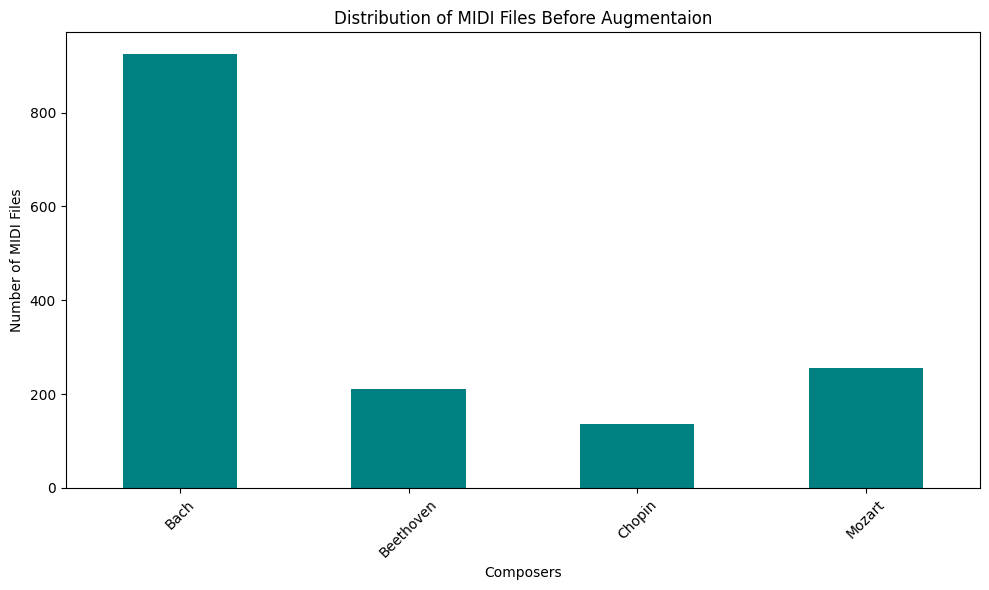

In [16]:
# Plot MIDI data distribution before augmentaion
# Convert list to pandas Series
composer_series = pd.Series(composer_labels)
# Count of each label
label_counts = composer_series.value_counts().sort_index()
# Map label counts to composer names
composer_counts = label_counts.rename(index=composer_map)

# Plotting the data
plt.figure(figsize=(10, 6))
composer_counts.plot(kind='bar', color='teal')
plt.xlabel('Composers')
plt.ylabel('Number of MIDI Files')
plt.title('Distribution of MIDI Files Before Augmentaion')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()

In [17]:
# Augmentation - skip 60% of midi_files for Bach
skip_percentage = 0.60
label_bach = 0
data_reduced = []
labels_reduced = []
skip_indices = augment_skip_composer_midi_files(composer_labels, label_bach, skip_percentage)
# Remove elements at specified indices
data_reduced = np.delete(midi_data, skip_indices)
labels_reduced = np.delete(composer_labels, skip_indices)

In [18]:
unique_composer, counts = np.unique(labels_reduced, return_counts=True)
print("After Bach MIDI files removed:")
for composer, count in zip(unique_composer, counts):
    print(f'composer: {composer_map[composer]},  sample size: {count}')

After Bach MIDI files removed:
composer: Bach,  sample size: 370
composer: Beethoven,  sample size: 211
composer: Chopin,  sample size: 136
composer: Mozart,  sample size: 256


In [19]:
composer_map

{0: 'Bach', 1: 'Beethoven', 2: 'Chopin', 3: 'Mozart'}

In [20]:
# Augmentation - create new 50% of midi_files for Beethoven, Chopin, and Mozart
data_extended = []
labels_extended = []

# Get the labels of composer for which midi_files need to be augmented
extend_midifiles_for = []
for key, value in composer_map.items():
        if value == 'Beethoven' or value == 'Chopin' or value == 'Mozart':
            extend_midifiles_for.append(key)

In [21]:
# Append the new midi files and labels in lists

def augment_MIDI_temporal(composer_labels, composer_label_index, extend_percentage, time_stretch):
    composer_indices = augment_extend_composer_midi_files(composer_labels, composer_label_index, extend_percentage)
    print("Composer ", composer_map[composer_label_index], "sample size = ", len(composer_indices))
    for i in composer_indices:
        stretched_midi = time_stretch_midi(midi_data[i], time_stretch)
        data_extended.append(stretched_midi)
        labels_extended.append(composer_label_index)

#Beethoven: augment 55% more than the current capacity by temoral reduction to 50%.
augment_MIDI_temporal(composer_labels, composer_label_index=1, extend_percentage = 0.55, time_stretch = 0.50) # reduce 50%
#Chopin: augment 100% more (double) than the current capacity by temoral reduction to 50%.
augment_MIDI_temporal(composer_labels, composer_label_index=2, extend_percentage = 1.0, time_stretch = 0.50)
#Mozart : augment 40% more than the current capacity by temoral reduction to 50%.
augment_MIDI_temporal(composer_labels, composer_label_index=3, extend_percentage = 0.40, time_stretch = 0.50)
#Chopin : augment 50% more than the current capacity by temoral increment to 50%.
augment_MIDI_temporal(composer_labels, composer_label_index=2, extend_percentage = 0.5, time_stretch = 1.50) # increase 50%


Composer  Beethoven sample size =  116
Composer  Chopin sample size =  136
Composer  Mozart sample size =  102
Composer  Chopin sample size =  68


In [22]:
#display_audio(data_extended[0])

In [23]:
midi_data_augmented = []
composer_labels_augmented = []
midi_data_augmented = np.append(data_reduced, data_extended)
composer_labels_augmented = np.append(labels_reduced, labels_extended)

In [24]:
print(midi_data_augmented.shape)
print(len(composer_labels_augmented))

(1395,)
1395


In [25]:
unique_composer, counts = np.unique(composer_labels_augmented, return_counts=True)
print("After MIDI file augmentaion:")
for composer, count in zip(unique_composer, counts):
    print(f'composer: {composer_map[composer]},  sample size: {count}')

After MIDI file augmentaion:
composer: Bach,  sample size: 370
composer: Beethoven,  sample size: 327
composer: Chopin,  sample size: 340
composer: Mozart,  sample size: 358


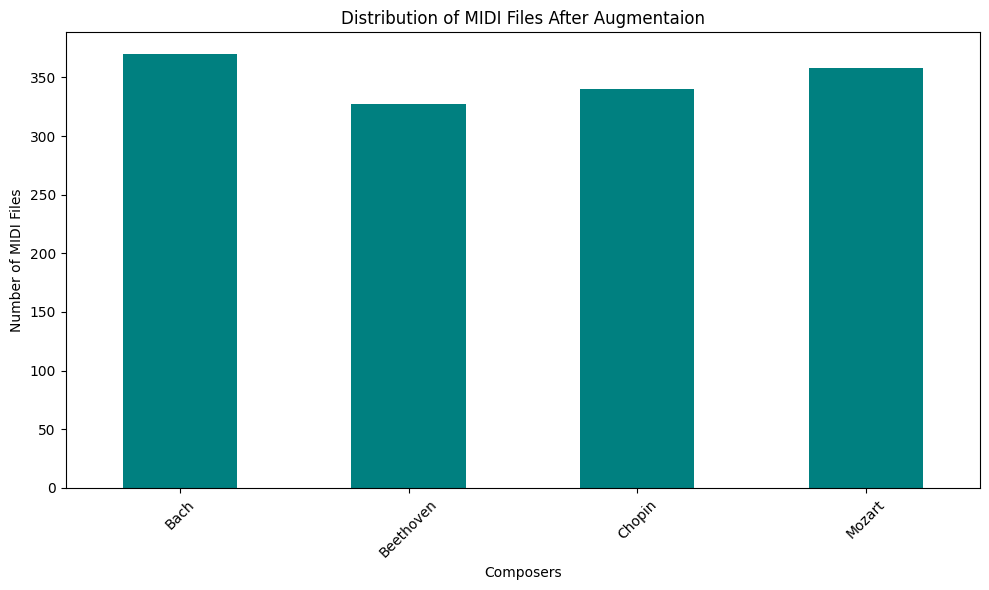

In [26]:
# Plot MIDI data distribution after augmentaion

# Convert list to pandas Series
composer_series = pd.Series(composer_labels_augmented)
# Count of each label
label_counts = composer_series.value_counts().sort_index()
# Map label counts to composer names
composer_counts = label_counts.rename(index=composer_map)

# Plotting the data
plt.figure(figsize=(10, 6))
composer_counts.plot(kind='bar', color='teal')
plt.xlabel('Composers')
plt.ylabel('Number of MIDI Files')
plt.title('Distribution of MIDI Files After Augmentaion')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()

## Data Pre-processing:

Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI
files and applying data augmentation techniques.


## EDA

# 1. Convolutional Neural Networks (CNN)

### Feature Extraction

# 2. Long Short-Term Memory networks(LSTM) Method 1/2

## Feature Extraction:



# 3. Long Short-Term Memory networks(LSTM) Method 2/2

In [27]:
class ComposerClassification_LSTM_Ngram:
    def __init__(self, dataset, labels, composer_map):
        self.composer_data = np.array(dataset)
        self.composer_labels = np.array(labels)
        self.tokenizer = None
        self.lstm_model = None
        self.composer_map = composer_map
        self.sequence_length = 100

    # Shuffle the augmented data few times
    def shuffle_data(self):
        for i in range(2):
          print("Shuffle:", i)
          # shuffled indices
          indices = np.arange(self.composer_data.shape[0])
          np.random.shuffle(indices)
          # Shuffling with same indices
          self.composer_data   = self.composer_data[indices]
          self.composer_labels = self.composer_labels[indices]

    # Split the midi_data_augmented data into two part one is to
    # train and validate the model and other is to test the model before any data pre-processing and feature extraction.
    def keep_unprocessed_data_for_prediction(self, percent = 0.2):
        # Calculate split index for 80/20 split
        split_index = int(len(self.composer_data) * (1-0.2))

        self.composer_data_Train, self.composer_data_Test = np.split(self.composer_data, [split_index])


        self.composer_labels_Train, self.composer_labels_Test = np.split(self.composer_labels, [split_index])

        print("Train Size:", len(self.composer_data_Train), len(self.composer_labels_Train))

        print("Test Size:", len(self.composer_data_Test), len(self.composer_labels_Test))
        return (self.composer_data_Train,  self.composer_labels_Train), (self.composer_data_Test, self.composer_labels_Test)

    # Plot labels
    def plot_train_test_labels(self):
        # Plot after rangom shuffles three times
        plt.figure(figsize=(8, 6))
        plt.plot(self.composer_labels_Train,'ro',  label='Train labels')
        plt.plot(self.composer_labels_Test ,'bo', label='Test labels')

        # Adding title and labels
        plt.title('label variations in train/test ')
        plt.xlabel('Index')
        plt.ylabel('label')
        plt.legend()
        plt.show()

    # Function to extract pitch sequences from a MIDI file
    def extract_pitch_sequences(self, mdata):
        sequences = []
        # Considering all instruments
        for i in np.arange(len(mdata.instruments)):
            previous_pitch = None
            instrument = mdata.instruments[i]
            if not instrument.is_drum:
                #pitches = [note.pitch for note in instrument.notes]
                # pitches.append(instrument.program)
                tokens = []
                for note in instrument.notes:
                    current_pitch = note.pitch
                    if previous_pitch is not None:
                        interval = current_pitch - previous_pitch
                    else:
                        interval = 0  # No interval for the first note
                    # Create new token by making a touple of pitch and pitch difference from previous
                    #token = (current_pitch, interval)
                    # Create new token by adding differnce from previos pitch to the token
                    # token = current_pitch + interval
                    # Create new token by concatenating current_pitch and interval as strings
                    token = str(current_pitch) + str(interval)
                    tokens.append(token)
                    previous_pitch = current_pitch

                sequences.extend(tokens)
        return sequences

    # create tokens of length sequence_length
    def create_n_grams(self, sequences, n):
        # Check if the sequence is shorter than the desired n-gram length
        if len(sequences) < n:
            # Pad the sequence with zeros at the end
            sequences = sequences + [0] * (n - len(sequences))
        # Generate n-grams
        return [' '.join(map(str, sequences[i:i+n])) for i in range(len(sequences) - n + 1)]

    # Extract features and labels from full train_set
    def create_sequence(self, sequence_len):
        self.sequence_length = sequence_len
        all_n_grams = []
        labels = []
        for data, composer in zip(self.composer_data_Train,self.composer_labels_Train):
            sequences = self.extract_pitch_sequences(data)
            # Ignore short sequences
            if(len(sequences) < self.sequence_length):
                print("Short sequence for ", composer)
                continue
            n_grams = self.create_n_grams(sequences,self.sequence_length)
            all_n_grams.extend(n_grams)
            labels.extend([composer] * len(n_grams))

        # Tokenization and sequence padding
        self.tokenizer = Tokenizer()
        self.tokenizer.fit_on_texts(all_n_grams)
        sequences = self.tokenizer.texts_to_sequences(all_n_grams)
        data = pad_sequences(sequences, maxlen=self.sequence_length)
        return (data, labels)

    # Save tokenizer. Same tokeniser should be used when testing the composer
    def save_tokenizer(self):
        # After training and creating the tokenizer
        self.tokenizer_name = 'tokenizer.pickle'
        with open(self.tokenizer_name, 'wb') as handle:
            pickle.dump(self.tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
            print("Saved tokenizer", self.tokenizer_name)

    # Split dataset for model training, validation, testing
    def splitDataset_train_val_test(self, data, labels, test_size=0.30):
       # Splitting the dataset
        self.X_train_sequence, X_temp, self.y_train_sequence, y_temp = train_test_split(data, labels, test_size=0.30, random_state=42)
        self.X_val_sequence,  self.X_test_sequence,  self.y_val_sequence,  self.y_test_sequence = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
        print("Train, val, test size", len(self.X_train_sequence), len(self.X_val_sequence), len(self.X_test_sequence) )
        # Label encoding
        label_encoder = LabelEncoder()
        self.y_train_sequence = label_encoder.fit_transform(self.y_train_sequence)
        self.y_val_sequence = label_encoder.transform(self.y_val_sequence)
        self.y_test_sequence  = label_encoder.transform( self.y_test_sequence )
        return

    def build_lstm2_model(self, input_dim, num_classes):
        self.lstm_model = Sequential([
            #Embedding(input_dim=input_dim, output_dim=64, input_length=self.sequence_length),
            Embedding(input_dim=input_dim, output_dim=64),
            LSTM(128, return_sequences=True),
            LSTM(128),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])
        # Compile the model
        self.lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        return self.lstm_model

    def train_evaluate_model(self, epochs=10, batch_size=256):
        # Train the model
        history = self.lstm_model.fit(self.X_train_sequence, self.y_train_sequence, epochs=epochs,
                                 batch_size=batch_size, validation_data=(self.X_val_sequence, self.y_val_sequence))
        test_loss, test_accuracy = self.lstm_model.evaluate(self.X_test_sequence, self.y_test_sequence)
        print("Test accuracy:", test_accuracy)
        print("Test loss:", test_loss)
        return history

    def plot_results(self, history):
        # Extracting performance metrics
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        epochs = range(1, len(acc) + 1)
        # Plotting all metrics
        plt.figure(figsize=(12, 8))
        plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
        plt.plot(epochs, val_acc, 'go-', label='Validation Accuracy')

        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    # Load the same tokenizer used to train the data
    def loadTokenizer(self):
        with open(self.tokenizer_name, 'rb') as handle:
            self.tokenizer = pickle.load(handle)
            return self.tokenizer

    # Predict from single midifile
    def predict_composer(self, testMidi):
        print("predict_composer")
        # Extract pitch sequences from the MIDI file
        sequences = self.extract_pitch_sequences(testMidi)
        n_grams = self.create_n_grams(sequences)

        # Tokenize and pad the sequences
        tokenizer = self.loadTokenizer()
        sequences = tokenizer.texts_to_sequences(n_grams)
        padded_sequences = pad_sequences(sequences, maxlen=self.sequence_length)

        # Make predictions
        predictions = self.lstm_model.predict(padded_sequences)
        predicted_index = np.argmax(predictions, axis=1)  #  multiple predictions: take the most common
        #predicted_composer = label_encoder.inverse_transform([np.bincount(predicted_index).argmax()])
        return predicted_index


    def testComposer(self, testMidi, actualLabel):
        composer_n_grams = []
        composer_label = []
        sequences = self.extract_pitch_sequences(testMidi)
        n_grams = self.create_n_grams(sequences)
        composer_n_grams.extend(n_grams)
        composer_label.extend([composer] * len(n_grams))
        # Tokenization and sequence padding
        tokenizer = self.loadTokenizer()
        sequences = tokenizer.texts_to_sequences(composer_n_grams)
        data = pad_sequences(sequences, maxlen=self.sequence_length)
        return data

    # Predict single composer
    def test_predict(self, midi_index=0):
        test_midi = self.composer_data[midi_index]
        actualLabel = self.composer_labels[midi_index]
        print(type(test_midi))
        predicted_composer_index = self.predict_composer(test_midi)
        count = Counter(predicted_composer_index)
        sorted_composer = count.most_common()
        print("Get highest probability of composer:")
        for e, f in sorted_composer:
            print(f"Element: {e}, Frequency: {f}")

        most_frequent = sorted_composer[0][0]
        print(f"Actual composer= {self.composer_map[actualLabel]},\nThe predicted composer is: {self.composer_map[most_frequent]}")

    ## Predict on unseen test set and evaluate the model
    def evaluate_unseen_dataset(self):
        predicted_composer = []
        # Load Tokenize
        tokenizer = self.loadTokenizer()
        all_n_grams_test = []
        labels_test = []
        skip_short_seq = []
        i = 0
        for index, (data, composer) in enumerate(zip(self.composer_data_Test,self.composer_labels_Test)):
            #print("composer ", composer, i)
            sequences = self.extract_pitch_sequences(data)
            # Ignore short sequences
            if(len(sequences) < self.sequence_length):
                print("Short sequence for ", composer)
                skip_short_seq.append(index)
                continue
            n_grams = self.create_n_grams(sequences, self.sequence_length)

            all_n_grams_test.extend(n_grams)
            labels_test.extend([composer] * len(n_grams))

            pitch_token = tokenizer.texts_to_sequences(n_grams)
            padded_sequences = pad_sequences(pitch_token, maxlen=self.sequence_length)

            # Make predictions
            predictions = self.lstm_model.predict(padded_sequences, verbose=0)
            predicted_index = np.argmax(predictions, axis=1)  #  multiple predictions: take the most common
            predicted_result = mode(predicted_index)
            predicted_composer.append(predicted_result.mode)
            i = i+ 1
        # Remove the rows in skip_short_seq
        self.composer_labels_Test = np.delete(self.composer_labels_Test, skip_short_seq)
        return predicted_composer

    def generate_report(self, predictions):
        print(classification_report(self.composer_labels_Test, predictions))

        # Confusion matix
        cm = confusion_matrix(self.composer_labels_Test, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Bach' , 'Beethoven', 'Chopin', 'Mozart'], yticklabels=['Bach' , 'Beethoven', 'Chopin', 'Mozart'])
        plt.title('Confusion matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        return


## Feature Extraction:

Extract features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.

In [28]:
lstm_classification = ComposerClassification_LSTM_Ngram(midi_data_augmented, composer_labels_augmented, composer_map)

In [29]:
lstm_classification.shuffle_data()

Shuffle: 0
Shuffle: 1


In [30]:
(train_set, test_set) = lstm_classification.keep_unprocessed_data_for_prediction()
print("Train set:", train_set[0].shape, "Test set:", test_set[0].shape)

Train Size: 1116 1116
Test Size: 279 279
Train set: (1116,) Test set: (279,)


In [31]:
print(lstm_classification.composer_data.shape, lstm_classification.composer_labels.shape)

(1395,) (1395,)


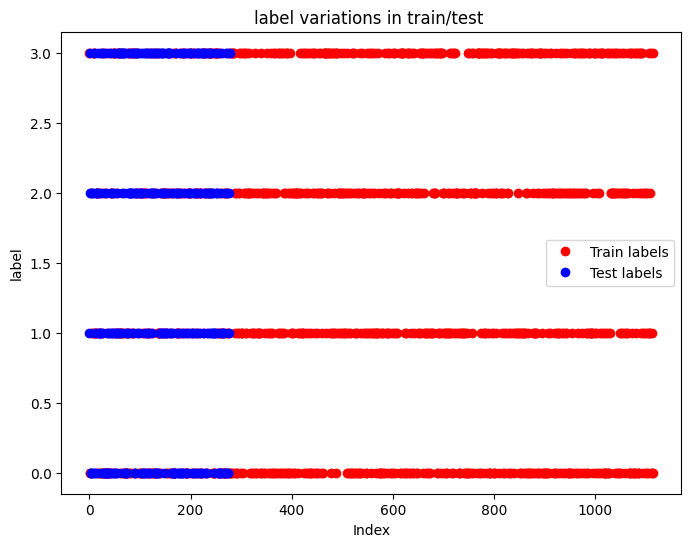

In [32]:
lstm_classification.plot_train_test_labels()

In [33]:
seq_length = 100
data, labels = lstm_classification.create_sequence(seq_length)
print("Data:", len(data), "labels:", len(labels))

Short sequence for  1
Data: 4683407 labels: 4683407


In [34]:
lstm_classification.save_tokenizer()

Saved tokenizer tokenizer.pickle


In [35]:
lstm_classification.splitDataset_train_val_test(data, labels)

Train, val, test size 3278384 702511 702512


## LSTM 2 Model Building:

Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.

In [36]:
input_dim = len(np.unique(data, axis=0))
output_dim = len(np.unique(labels))

In [37]:
# Build the lstm model with enbedding layer as first layer.
lstm_model = lstm_classification.build_lstm2_model(input_dim, output_dim)

## LSTM 2 Model Architecture

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 64)             │     199,439,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 199,670,340 (761.68 MB)

 Trainable params: 199,670,340 (761.68 MB)

 Non-trainable params: 0 (0.00 B)

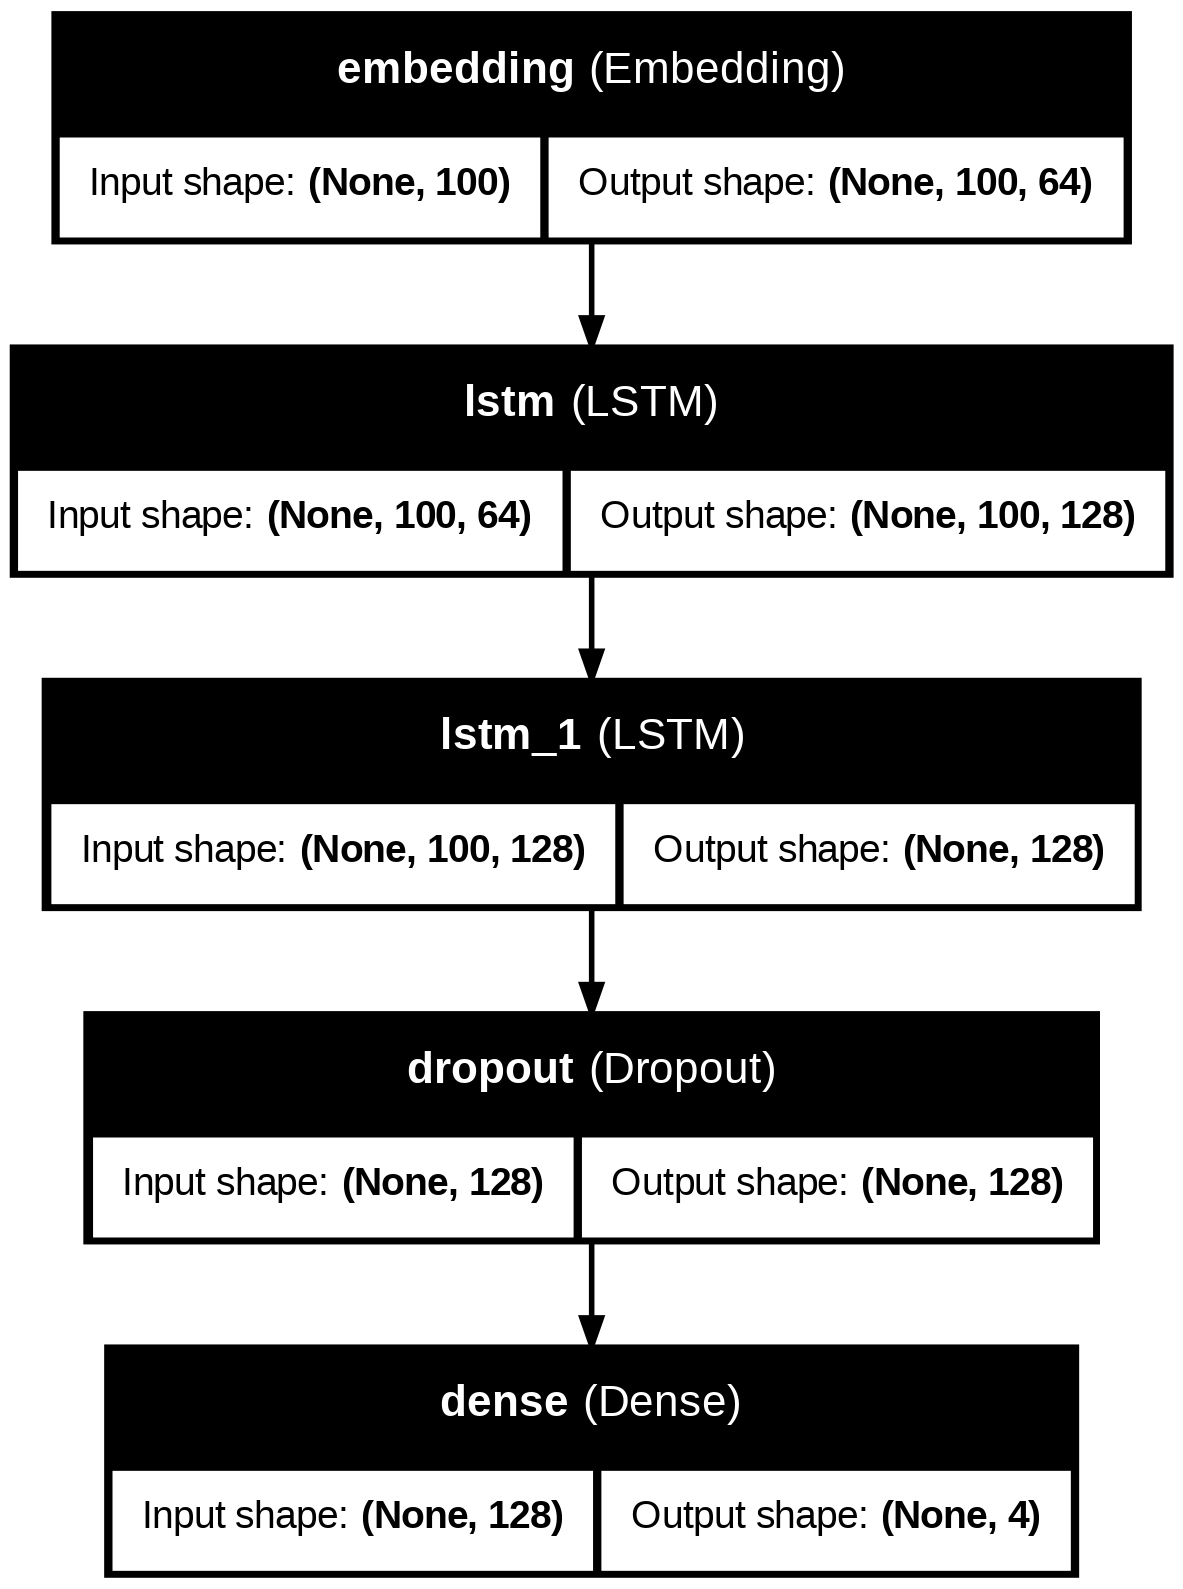

In [38]:
# Create model summary and visualize
# None for batch size, sequence_length for feature size
lstm_model.build((None, sequence_length))
lstm_model.summary()
plot_model(lstm_model, show_shapes=True, show_layer_names=True)

## LSTM 2 Model Training

For LSTM model we use sparse_categorical_crossentropy as the loss function. This loss function is designed to handle integer targets directly, interpreting the integer as the index of the true class.


In [39]:
history = lstm_classification.train_evaluate_model(epochs=10, batch_size=256)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 199439424 elements. This may consume a large amount of memory.
  warnings.warn(


12807/12807 ━━━━━━━━━━━━━━━━━━━━ 391s 30ms/step - accuracy: 0.6840 - loss: 0.7224 - val_accuracy: 0.9309 - val_loss: 0.1924
Epoch 2/10
12807/12807 ━━━━━━━━━━━━━━━━━━━━ 387s 30ms/step - accuracy: 0.9500 - loss: 0.1431 - val_accuracy: 0.9810 - val_loss: 0.0541
Epoch 3/10
12807/12807 ━━━━━━━━━━━━━━━━━━━━ 388s 30ms/step - accuracy: 0.9836 - loss: 0.0477 - val_accuracy: 0.9897 - val_loss: 0.0296
Epoch 4/10
12807/12807 ━━━━━━━━━━━━━━━━━━━━ 391s 31ms/step - accuracy: 0.9901 - loss: 0.0288 - val_accuracy: 0.9911 - val_loss: 0.0254
Epoch 5/10
12807/12807 ━━━━━━━━━━━━━━━━━━━━ 391s 31ms/step - accuracy: 0.9926 - loss: 0.0217 - val_accuracy: 0.9937 - val_loss: 0.0180
Epoch 6/10
12807/12807 ━━━━━━━━━━━━━━━━━━━━ 387s 30ms/step - accuracy: 0.9938 - loss: 0.0181 - val_accuracy: 0.9947 - val_loss: 0.0149
Epoch 7/10
12807/12807 ━━━━━━━━━━━━━━━━━━━━ 388s 30ms/step - accuracy: 0.9948 - loss: 0.0152 - val_accuracy: 0.9948 - val_loss: 0.0148
Epoch 8/10
12807/12807 ━━━━━━━━━━━━━━━━━━━━ 387s 30ms/step - accur

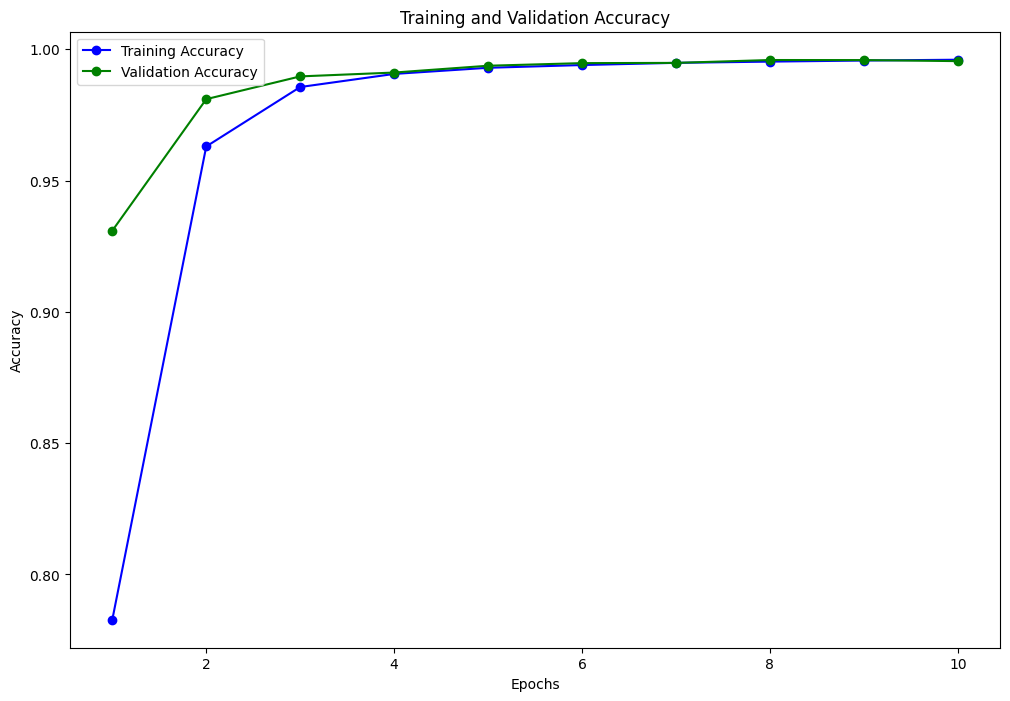

In [40]:
lstm_classification.plot_results(history)

## LSTM 2 Model Evaluation

In [41]:
predictions = lstm_classification.evaluate_unseen_dataset()

              precision    recall  f1-score   support

           0       0.97      0.91      0.94        75
           1       0.84      0.92      0.88        62
           2       0.97      1.00      0.99        70
           3       0.94      0.90      0.92        72

    accuracy                           0.93       279
   macro avg       0.93      0.93      0.93       279
weighted avg       0.93      0.93      0.93       279



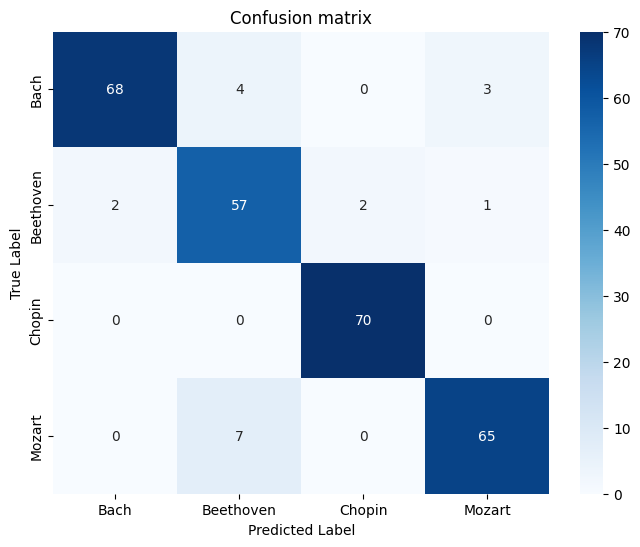

In [42]:
lstm_classification.generate_report(predictions)

## LSTM 2 test

In [43]:
#lstm_classification.test_predict(midi_index=0)

## LSTM 2  Model Optimization:

Optimize the deep learning model by fine-tuning hyperparameters on full dataset.

Batch_Size Num_Epochs  Test accuracy

512           10          88%

256           10          92%
                   precision    recall  f1-score   support

           0       1.00      0.79      0.89        68
           1       0.86      0.95      0.91        66
           2       1.00      1.00      1.00        69
           3       0.84      0.92      0.88        75



128           10          85%


# Conclusion

# Future EnhancementsConclusion

#  References

In [44]:
"""
# Generate pdf colab
def colab2pdf():
    # Colab2PDF by Drengskapur (https://github.com/drengskapur/colab2pdf)
    # @title Convert Colab Notebook to PDF {display-mode:'form'}
    # VERSION 1.3
    # LICENSE: GPL-3.0-or-later
    !apt-get install -yqq --no-install-recommends librsvg2-bin>/dev/null
    import contextlib,datetime,google,io,IPython,ipywidgets,json,locale,nbformat,os,pathlib,requests,urllib,warnings,werkzeug,yaml;locale.setlocale(locale.LC_ALL,'en_US.UTF-8')
    def convert(b):
        try:
            s.value='⚙️ Converting...';b.disabled=True;get_ipython().events.register('post_execute',lambda:IPython.display.display(IPython.display.Javascript('document.querySelectorAll("#output-footer").forEach(footer=>footer.remove());')))
            n=pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f'http://{os.environ["COLAB_JUPYTER_IP"]}:{os.environ["KMP_TARGET_PORT"]}/api/sessions').json()[0]['name'])))
            p=pathlib.Path('/content/pdfs')/f'{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}_{n.stem}';p.mkdir(parents=True,exist_ok=True);warnings.filterwarnings('ignore',category=nbformat.validator.MissingIDFieldWarning)
            nb=[cell for cell in nbformat.reads(json.dumps(google.colab._message.blocking_request('get_ipynb',timeout_sec=600)['ipynb']),as_version=4).cells if '--Colab2PDF' not in cell.source]
            with (p/f'{n.stem}.ipynb').open('w',encoding='utf-8') as cp:nbformat.write(nbformat.v4.new_notebook(cells=nb or [nbformat.v4.new_code_cell('#')]),cp)
            with (p/'config.yml').open('w',encoding='utf-8') as f:yaml.dump({'include-in-header':[{'text':r'\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}'}],'include-before-body':[{'text':r'\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}'}]},f)
            !quarto render {p}/{n.stem}.ipynb --metadata-file={p}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
            google.colab.files.download(str(p/f'{n.stem}.pdf'));s.value=f'🎉 Downloaded {n.stem}.pdf'
        except Exception as e:
            s.value=f'⚠️ ERROR {str(e)}'
        finally:
            b.disabled=False
    if not pathlib.Path('/usr/local/bin/quarto').exists():
        !wget -q 'https://quarto.org/download/latest/quarto-linux-amd64.deb' -P {p} && dpkg -i {p}/quarto-linux-amd64.deb>/dev/null && quarto install tinytex --update-path --quiet
    b=ipywidgets.widgets.Button(description='⬇️ Download PDF');s=ipywidgets.widgets.Label();b.on_click(lambda b:convert(b));IPython.display.display(ipywidgets.widgets.HBox([b,s]))
    IPython.display.display(IPython.display.Javascript('document.currentScript.parentElement.closest(".output_subarea").querySelector("#output-footer > input").remove();'))
# colab2pdf()
"""

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 1664-1665: truncated \uXXXX escape (<ipython-input-44-9590273692f9>, line 29)